# Weeks 7 and 8. Machine learning
# Part 1. Classification
Machine learning is a very general term that covers many parts of data science. Here, we will look at two specific problems that machine learning is well equipped to handle:
* Classification problems (this notebook)
* Clustering (next notebook)

As a broad generalization, machine learning-based classification focuses on *prediction*. For example: [which neighborhoods are likely to gentrify](https://journals.sagepub.com/doi/abs/10.1177/0042098018789054)? [Which facilities are likely to be violating environmental standards?](https://www.nature.com/articles/s41893-018-0142-9) What is demand likely to be at a new bikeshare station? [What is the race and gender of an author on a course reading list](http://syllabusdiversity.org)?

There are also applications which raise more concerns with ethics and justice (yes, [predictive policing](https://www.technologyreview.com/2020/07/17/1005396/predictive-policing-algorithms-racist-dismantled-machine-learning-bias-criminal-justice/), I'm talking about you). We'll come back to these issues in a couple of weeks.

Machine learning is less successful with questions of *causation* and *hypothesis testing*. Here, a statistical approach (frequentist or Bayesian) is likely to be more appropriate, although there is quite a bit of overlap between "statistics" and "machine learning."

There are at least three widely used approaches to classification.
* Logistic regression. This is often used in a more statistical setting, but is the starting point for much machine learning analysis. 
* Random forests. We'll focus on this technique.
* Neural networks. Often used for image recognition, this can be a "black box" approach to prediction and classification.

Important: machine learning is a very large field, and there are entire courses on the theory and applications. Here, we will give a very high-level overview. We'll focus on the big-picture applicability of machine learning techniques, and actually implementing them in Python. We'll skate over the theoretical underpinnings and the details of the various algorithms.

## Example: ADUs in LA
The example we will use is whether property owners construct Accessory Dwelling Units (ADUs) in the City of Los Angeles. You might imagine that a predictive approach could be useful to planners and policymakers. Not least, they could predict future ADU growth, and the neighborhoods where ADUs are most likely to be built.

We can obtain the data from the City's building permits database (which tells us whether or not an ADU was built), and the County Assessor parcel database (which provides covariates such as lot size). Because both of these datasets are very large, I preprocessed them and saved a slimmed-down version that is in your GitHub folder. Specifically, I extracted a subset of fields, limited the building permits to those that include an ADU, and limited the parcels to those in the City of LA.

## Wrangling the data
We have two input data files: permits and parcels. The aim: add a column to the parcels dataframe that is `True` if an ADU has been permitted on that parcel, and `False` otherwise.
    
Even with this preprocessing, there is some work to do in joining the datasets together. 

In [28]:
%config Completer.use_jedi = False
import pandas as pd

# get building permit data
# this is an abbreviated version of the data here (>500 MB):
# https://data.lacity.org/City-Infrastructure-Service-Requests/Building-and-Safety-Permit-Information-Old/yv23-pmwf

# this code was used to read in the data and save a subset (ADU permits only) that is manageable in size
if 0:  # if 0 means this block won't be executed
    cols_to_use = ['Assessor Book', 'Assessor Page', 'Assessor Parcel', '# of Accessory Dwelling Units']
    df = pd.read_csv('/Users/adammb/Desktop/Building_and_Safety_Permit_Information_Old.csv', usecols=cols_to_use)
    df = df[df['# of Accessory Dwelling Units']>0]
    df.to_csv('ADU_permits.csv', index=False)
    del df

permits = pd.read_csv('ADU_permits.csv')  # this file should be in your GitHub folder
permits.head()    

,Assessor Book,Assessor Page,Assessor Parcel,# of Accessory Dwelling Units
0,2340.0,20.0,013,1.0
1,5535.0,34.0,001,1.0
2,2639.0,23.0,005,1.0
3,2276.0,18.0,028,1.0
4,4249.0,6.0,016,1.0


In [29]:
# original data: https://egis-lacounty.hub.arcgis.com/datasets/parcels
# this code was used to read in the data and save a subset (City of LA only, subset of columns) that is manageable in size

import geopandas as gpd

if 0: # if 0 means this block won't be executed
    gdf = gpd.read_file('/Users/adammb/Desktop/LACounty_Parcels.gdb', driver='FileGDB', layer='LACounty_Parcels')
    gdf.dropna(subset=['SitusCity'], inplace=True)
    gdf = gdf[gdf['SitusCity'].str.startswith('LOS ANGELE')]
    cols_to_use = ['APN', 'UseType', 'UseDescription','YearBuilt1', 'Units1','Bedrooms1', 'Bathrooms1', 
         'SQFTmain1','Roll_LandValue', 'Roll_ImpValue', 'Roll_LandBaseYear', 'Roll_ImpBaseYear', 'CENTER_LAT', 'CENTER_LON']
    parceldf = pd.DataFrame(gdf)[cols_to_use]  # drops the geometry column as well
    parceldf.to_csv('parcels.csv', index=False)
    del gdf   # frees up space

parcels = pd.read_csv('parcels.csv')
parcels.head()

,APN,UseType,UseDescription,YearBuilt1,Units1,Bedrooms1,Bathrooms1,SQFTmain1,Roll_LandValue,Roll_ImpValue,Roll_LandBaseYear,Roll_ImpBaseYear,CENTER_LAT,CENTER_LON
0,2004-001-003,Residential,Single,1973.0,1.0,4.0,3.0,2090.0,543000.0,231000.0,2006,2006,34.220220,-118.620669
1,2004-001-004,Residential,Single,1973.0,1.0,5.0,3.0,2479.0,345587.0,238650.0,2010,2010,34.220039,-118.620668
2,2004-001-005,Residential,Single,1973.0,1.0,4.0,2.0,2057.0,490917.0,185207.0,2018,2018,34.219858,-118.620676
3,2004-001-008,Residential,Single,1978.0,1.0,4.0,3.0,2423.0,119775.0,207020.0,1980,1980,34.220334,-118.622706
4,2004-001-009,Residential,Single,1978.0,1.0,4.0,3.0,2226.0,130511.0,195871.0,1984,1984,34.220323,-118.623050


Note that the `APN` column in `parcels` has a format that corresponds to three columns in `permits`: `Assessor Book`-`Assessor Page`-`Assessor Parcel`. 

So the first step is to create this `APN` column in `permits`.

In [ ]:
# join
permits['APN'] = (permits['Assessor Book'].astype(int).astype(str).str.zfill(4) + '-' 
                   + permits['Assessor Page'].astype(int).astype(str).str.zfill(3) + '-'
                   + permits['Assessor Parcel'].astype(int).astype(str).str.zfill(3))

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> What went wrong?
</div>

In [31]:
# solution
# first, we need to drop the NaNs. They won't join anyway
permits.dropna(subset=['Assessor Book', 'Assessor Page','Assessor Parcel'], inplace=True)

In [ ]:
# then we run the code again, but we get another error. 
permits['APN'] = (permits['Assessor Book'].astype(int).astype(str).str.zfill(4) + '-' 
                   + permits['Assessor Page'].astype(int).astype(str).str.zfill(3) + '-'
                   + permits['Assessor Parcel'].astype(int).astype(str).str.zfill(3))

In [33]:
# Let's look at these rows 
permits[permits['Assessor Parcel']=='***']

,Assessor Book,Assessor Page,Assessor Parcel,# of Accessory Dwelling Units
1585,2307.0,23.0,***,1.0
4652,5084.0,28.0,***,1.0
5523,2219.0,6.0,***,1.0
12083,2340.0,29.0,***,1.0
13982,2653.0,23.0,***,6.0
14514,2603.0,11.0,***,1.0


In [34]:
# OK, we should drop them
permits = permits[permits['Assessor Parcel']!='***']
permits['APN'] = (permits['Assessor Book'].astype(int).astype(str).str.zfill(4) + '-' 
                   + permits['Assessor Page'].astype(int).astype(str).str.zfill(3) + '-'
                   + permits['Assessor Parcel'].astype(int).astype(str).str.zfill(3))
permits.head()

,Assessor Book,Assessor Page,Assessor Parcel,# of Accessory Dwelling Units,APN
0,2340.0,20.0,013,1.0,2340-020-013
1,5535.0,34.0,001,1.0,5535-034-001
2,2639.0,23.0,005,1.0,2639-023-005
3,2276.0,18.0,028,1.0,2276-018-028
4,4249.0,6.0,016,1.0,4249-006-016


<div class="alert alert-block alert-info">
<strong>Question:</strong> What type of join do we want? Left? Right? Inner? Outer? 1:1? 1:many?
</div>

Note two things:
* We need to keep all of the parcels, even if there isn't a corresponding permit. Otherwise, we can't do any prediction—we'll have dataset where *every* parcel has an ADU. So that implies a left join to the parcels dataframe
* We don't want to duplicate parcels. So let's drop any duplicates (on the APN column) in both the permit and parcels dataframes. That will guarantee a 1:1 join

There are two ways to drop duplicates: the [pandas `drop_duplicates()` function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html) is one. But sometimes it's easier to use `groupby`, and then take the first in each group. If there is only one row in a group, it will be returned unchanged.

In [37]:
# in the permits, take the first row of any duplicates for convenience
print('Before dropping duplicates: {}'.format(len(permits)))
permits = permits.groupby('APN').first()
print('After dropping duplicates: {}'.format(len(permits)))
permits.index.is_unique  # make sure the index (APN) is unique

Before dropping duplicates: 15735
After dropping duplicates: 15348


True

In [38]:
print('Before dropping duplicates: {}'.format(len(parcels)))
parcels = parcels.groupby('APN').first()
print('After dropping duplicates: {}'.format(len(parcels)))
parcels.index.is_unique  # make sure the index (APN) is unique

Before dropping duplicates: 789182
After dropping duplicates: 789156


True

Now let's do the join.

In [100]:
joinedDf = parcels.join(permits, how='left')
print('N parcels: {}'.format(len(joinedDf)))
print('N joined: {}'.format(joinedDf['# of Accessory Dwelling Units'].count()))
joinedDf.head()

N parcels: 789156
N joined: 15142


,UseType,UseDescription,YearBuilt1,Units1,Bedrooms1,Bathrooms1,SQFTmain1,Roll_LandValue,Roll_ImpValue,Roll_LandBaseYear,Roll_ImpBaseYear,CENTER_LAT,CENTER_LON,Assessor Book,Assessor Page,Assessor Parcel,# of Accessory Dwelling Units
APN,,,,,,,,,,,,,,,,,
2004-001-003,Residential,Single,1973.0,1.0,4.0,3.0,2090.0,543000.0,231000.0,2006,2006,34.220220,-118.620669,NaN,NaN,NaN,NaN
2004-001-004,Residential,Single,1973.0,1.0,5.0,3.0,2479.0,345587.0,238650.0,2010,2010,34.220039,-118.620668,NaN,NaN,NaN,NaN
2004-001-005,Residential,Single,1973.0,1.0,4.0,2.0,2057.0,490917.0,185207.0,2018,2018,34.219858,-118.620676,NaN,NaN,NaN,NaN
2004-001-008,Residential,Single,1978.0,1.0,4.0,3.0,2423.0,119775.0,207020.0,1980,1980,34.220334,-118.622706,NaN,NaN,NaN,NaN
2004-001-009,Residential,Single,1978.0,1.0,4.0,3.0,2226.0,130511.0,195871.0,1984,1984,34.220323,-118.623050,NaN,NaN,NaN,NaN


That seems good enough. We join almost all of the permits to the parcels dataframe. 

Now let's create a column that is 0 if there is no ADU (i.e., if the permit data did not join), and 1 otherwise.

In [101]:
# we are using the '# of Accessory Dwelling Units' column, but any column would work fine
joinedDf['hasADU'] = joinedDf['# of Accessory Dwelling Units'].apply(lambda x: 0 if pd.isnull(x) else 1)
joinedDf.head()

,UseType,UseDescription,YearBuilt1,Units1,Bedrooms1,Bathrooms1,SQFTmain1,Roll_LandValue,Roll_ImpValue,Roll_LandBaseYear,Roll_ImpBaseYear,CENTER_LAT,CENTER_LON,Assessor Book,Assessor Page,Assessor Parcel,# of Accessory Dwelling Units,hasADU
APN,,,,,,,,,,,,,,,,,,
2004-001-003,Residential,Single,1973.0,1.0,4.0,3.0,2090.0,543000.0,231000.0,2006,2006,34.220220,-118.620669,NaN,NaN,NaN,NaN,0
2004-001-004,Residential,Single,1973.0,1.0,5.0,3.0,2479.0,345587.0,238650.0,2010,2010,34.220039,-118.620668,NaN,NaN,NaN,NaN,0
2004-001-005,Residential,Single,1973.0,1.0,4.0,2.0,2057.0,490917.0,185207.0,2018,2018,34.219858,-118.620676,NaN,NaN,NaN,NaN,0
2004-001-008,Residential,Single,1978.0,1.0,4.0,3.0,2423.0,119775.0,207020.0,1980,1980,34.220334,-118.622706,NaN,NaN,NaN,NaN,0
2004-001-009,Residential,Single,1978.0,1.0,4.0,3.0,2226.0,130511.0,195871.0,1984,1984,34.220323,-118.623050,NaN,NaN,NaN,NaN,0


## Train-test split
In almost any prediction problem, we want to split the data into a "training sample" and a "testing sample". Assuming you have a large enough sample, this helps to evaluate the performance of your machine learning model. Essentially, you are assessing how well the model performs against new data that it has not seen before.

`scikit-learn` has built in functions to split the data. Note that this chooses a random sample. If you want to replicate your analysis, the `random_state` argument can do that.

In [45]:
from sklearn.model_selection import train_test_split
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to t

At this point, we also need to choose our variables. Our `y` variable is whether there is an ADU or not: `hasADU`.

For our `x` (predictor) variables, let's start with a few: `['SQFTmain1', 'Roll_LandValue', 'Roll_ImpValue']`.

We also need to drop Null values. Some `pandas` and `numpy` functions do this automatically, but the `scikit-learn` functions normally require us to drop the Null values ourselves.

In [49]:
xvars = ['SQFTmain1', 'Roll_LandValue', 'Roll_ImpValue']
yvar = 'hasADU'

# create a dataframe with no NaNs
df_to_fit = joinedDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

581968 581968
193990 193990


## Random Forests
Now we are ready to do some machine learning!

Random forests are based on the idea of a decision tree. At the crudest level, imagine a classifier that predicts `hasADU=True` if the lot is residential and larger than 5,000sf, and `hasADU=False` otherwise. (The exact threshold such as 5,000sf is estimated from the data.)

Here's the example from the Reades et al. article about urban gentrification.

<img src="10.1177_0042098018789054-fig1.jpg" width="600">

Such a deterministic tree is unlikely to do a great job in prediction. Enter random forests, which are a collection of decision trees. Each tree is trained on a subsample of the data. Then the predictions are combined, rather like the "wisdom of crowds." Formally, this process is called *ensemble learning*.

[For a more in-depth explanation, see this article by Neil Liberman.](https://towardsdatascience.com/decision-trees-and-random-forests-df0c3123f991)

Random forests are implemented in `scikit-learn`. An important parameter is the `n_estimators` (i.e., the number of trees). Up to a point, more trees will mean better predictions. But more trees also mean that the code will run more slowly. A general rule: get it working with a small number of trees.

Even with 50 trees, you might hear your computer fan run a bit faster.

In [55]:
from sklearn.ensemble import RandomForestClassifier # note there is also a RandomForestRegressor

# initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=1)

Once we've estimated the model, we can apply it to predict whether an ADU will be built on an "unseen" parcel. In other words, we apply the predictions to the *test* dataset.

In [62]:
y_pred = rf.predict(X_test)

How can we assess the performance of this model? One quick check is to look at the means (i.e., the percentage `True`) in each sample.

In [71]:
print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(y_pred.mean(), y_test.mean()))

Predicted frc True: 0.0002. Actual frc True: 0.0194


So that doesn't look too good. We can also look more formally at the predictive accuracy.

`scikit-learn` has several useful functions here:
* The [*confusion matrix*](https://en.wikipedia.org/wiki/Confusion_matrix) gives the number of observations that fall into each predicted and actual category (e.g is True and predicted to be True - a "true positive")
* The [*accuracy score*](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score) gives the fraction of accurate predictions. A high score is no guarantee of a good model. Suppose you want to predict whether a person will be struck by lightening tomorrow. Then just predict "No" for everyone. Accurate, but not useful!
* The [*classification report*](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) reports key metrics for each category (in this case, `True` and `False`. *Precision* gives the fraction of true positives (TP / (TP + FP). *Recall* gives the fraction of true positives (TP / (TP + FN).

In [74]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix

print(confusion_matrix(y_test, y_pred))
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

[[190195     38]
 [  3756      1]]
Accuracy score: 0.9804
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    190233
           1       0.03      0.00      0.00      3757

    accuracy                           0.98    193990
   macro avg       0.50      0.50      0.50    193990
weighted avg       0.96      0.98      0.97    193990



We can also plot the confusion matrix. Note the colorbar shows the number of observations.

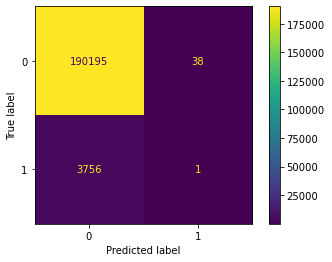

In [78]:
plot_confusion_matrix(rf, X_test, y_test)

That was a useful proof-of-concept. But our predictions were pretty dire. We might be able to fix this by:
* Adding more variables
* Adding more trees
* Adjusting other hyperparameters (we won't discuss that here)

Let's throw all the variables in our dataset into the model. This would be bad practice for a hypothesis-testing oriented statistical model. But with prediction, we can throw in the kitchen sink, and rely on the model to separate out what is useful.

Note that string variables need to be encoded into dummy variables before we can use them. For example, our `UseType` and `UseDescription` variables need to be split into a series of True or False variables such as `Residential`, `Commercial`, etc.

In [94]:
joinedDf.UseType.unique()

array(['Residential', 'Commercial', 'Recreational', 'Government',
       'Institutional', 'Industrial', 'Miscellaneous', None,
       'Irrigated Farm'], dtype=object)

In [95]:
joinedDf.UseDescription.unique()

array(['Single', 'Office Buildings',
       'Clubs., Lodge Halls, Fraternal Organizations', 'Stores',
       'Store Combination', 'Five or more apartments',
       'Restaurants, Cocktail Lounges', 'Two Units', 'Government Parcel',
       'Hospitals', 'Shopping Centers (Neighborhood, community)',
       'Department Stores', 'Professional Buildings',
       'Homes For Aged & Others', 'Schools (Private)', 'Churches',
       'Nurseries or Greenhouses', 'Service Stations', 'Hotel & Motels',
       'Auto, Recreation EQPT, Construction EQPT, Sales & Service',
       'Parking Lots (Commercial Use Properties)',
       'Athletic & Amusement Facilities', 'Supermarkets',
       'Banks Savings & Loan', 'Four Units (Any Combination)',
       'Three Units (Any Combination)', 'Commercial',
       'Shopping Centers (Regional)', 'Open', 'Rooming Houses',
       'Bowling Alleys', 'Mobile Homes',
       'Lgt Manf.Sm. EQPT. Manuf Sm.Shps Instr.Manuf. Prnt Plnts',
       'Warehousing, Distribution, Storage'

In [104]:
dummies1 = pd.get_dummies(joinedDf.UseType, prefix='usetype_')  # creates a dataframe of dummies
dummies2 = pd.get_dummies(joinedDf.UseDescription, prefix='usedesc_')
dummies1

,usetype__Commercial,usetype__Government,usetype__Industrial,usetype__Institutional,usetype__Irrigated Farm,usetype__Miscellaneous,usetype__Recreational,usetype__Residential
APN,,,,,,,,
2004-001-003,0,0,0,0,0,0,0,1
2004-001-004,0,0,0,0,0,0,0,1
2004-001-005,0,0,0,0,0,0,0,1
2004-001-008,0,0,0,0,0,0,0,1
2004-001-009,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
7563-037-053,0,0,0,0,0,0,0,1
7563-037-054,0,0,0,0,0,0,0,1
7563-037-055,0,0,0,0,0,0,0,1


In [105]:
# join back to the original dataframe
joinedDf = joinedDf.join(dummies1).join(dummies2) 
joinedDf.head()

,UseType,UseDescription,YearBuilt1,Units1,Bedrooms1,Bathrooms1,SQFTmain1,Roll_LandValue,Roll_ImpValue,Roll_LandBaseYear,...,usedesc__Theaters,usedesc__Three Units (Any Combination),usedesc__Timber-Pine,usedesc__Two Units,usedesc__Utility Commercial & Mutual: Pumping Plants State Assessed Pr,usedesc__Vineyards,"usedesc__Warehousing, Distribution, Storage",usedesc__Waste,usedesc__Water Recreation,usedesc__Wholesale & Manufacturing Outlets
APN,,,,,,,,,,,,,,,,,,,,,
2004-001-003,Residential,Single,1973.0,1.0,4.0,3.0,2090.0,543000.0,231000.0,2006,...,0,0,0,0,0,0,0,0,0,0
2004-001-004,Residential,Single,1973.0,1.0,5.0,3.0,2479.0,345587.0,238650.0,2010,...,0,0,0,0,0,0,0,0,0,0
2004-001-005,Residential,Single,1973.0,1.0,4.0,2.0,2057.0,490917.0,185207.0,2018,...,0,0,0,0,0,0,0,0,0,0
2004-001-008,Residential,Single,1978.0,1.0,4.0,3.0,2423.0,119775.0,207020.0,1980,...,0,0,0,0,0,0,0,0,0,0
2004-001-009,Residential,Single,1978.0,1.0,4.0,3.0,2226.0,130511.0,195871.0,1984,...,0,0,0,0,0,0,0,0,0,0


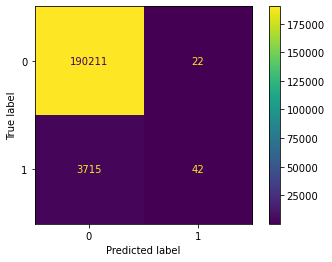

In [126]:
xvars = (dummies1.columns.tolist() + dummies2.columns.tolist() + 
            ['YearBuilt1', 'Units1', 'Bedrooms1', 'Bathrooms1', 'SQFTmain1', 'Roll_LandValue', 
             'Roll_ImpValue', 'Roll_LandBaseYear', 'Roll_ImpBaseYear', 'CENTER_LAT', 'CENTER_LON' ])
yvar = 'hasADU'

# create a dataframe with no NaNs
df_to_fit = joinedDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

rf = RandomForestClassifier(n_estimators = 100, random_state = 1, n_jobs=-1) # n_jobs uses all your computer's cores

# now fit the model
rf.fit(X_train, y_train)

plot_confusion_matrix(rf, X_test, y_test)

In [129]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    190233
           1       0.66      0.01      0.02      3757

    accuracy                           0.98    193990
   macro avg       0.82      0.51      0.51    193990
weighted avg       0.97      0.98      0.97    193990



A bit better. In particular, we do a much better job in getting the true positives (see our precision score). 

It's still not great. But this is not surprising: ADU construction will depend on many factors that are outside our dataset: lot shape, the ability of the owners to afford an ADU, and their personal circumstances (e.g. having an elderly family member). Bringing census data and other predictors might help.

But even if the predictions are not always accurate, the predicted *probabilities* can be informative. We could even map them to indicate where ADUs are likely to be built. 

We can access the probabilities from the `rf` object. Note it gives us a matrix: the first column is the probability of `True`, and the second is the probability of `False`.

In [132]:
rf.predict_proba(X_test)

array([0.98, 0.99, 0.99, ..., 1.  , 1.  , 1.  ])

In [161]:
# create a dataframe
predictions = pd.DataFrame(rf.predict_proba(X_test), columns = ['pred_noADU', 'pred_ADU'])
predictions.head()

,pred_noADU,pred_ADU
0,0.98,0.02
1,0.99,0.01
2,0.99,0.01
3,1.00,0.00
4,1.00,0.00


In [162]:
# join will join on the index. But X_test has our original index. predictions has an integer index. 
# reset_index() will create a new integer index for X_test
predictions= predictions.join(X_test.reset_index())
predictions.head()

,pred_noADU,pred_ADU,APN,usetype__Commercial,usetype__Government,usetype__Industrial,usetype__Institutional,usetype__Irrigated Farm,usetype__Miscellaneous,usetype__Recreational,...,Units1,Bedrooms1,Bathrooms1,SQFTmain1,Roll_LandValue,Roll_ImpValue,Roll_LandBaseYear,Roll_ImpBaseYear,CENTER_LAT,CENTER_LON
0,0.98,0.02,4425-019-013,0,0,0,0,0,0,0,...,1.0,4.0,4.0,3645.0,3788626.0,1747000.0,2014,2020,34.056747,-118.502173
1,0.99,0.01,2731-012-045,0,0,0,0,0,0,0,...,1.0,4.0,2.0,1252.0,174849.0,117647.0,2004,2004,34.258152,-118.528015
2,0.99,0.01,4409-024-016,0,0,0,0,0,0,0,...,1.0,3.0,2.0,1452.0,1872720.0,208080.0,2018,2018,34.040218,-118.516832
3,1.00,0.00,5460-001-063,0,0,0,0,0,0,0,...,1.0,3.0,4.0,1550.0,506736.0,217464.0,2019,2019,34.119620,-118.230406
4,1.00,0.00,5041-023-040,0,0,0,0,0,0,0,...,1.0,2.0,1.0,801.0,230114.0,57524.0,2008,2008,34.021307,-118.310995


In [163]:
# add a geometry column
import geopandas as gpd
predictions = gpd.GeoDataFrame(predictions, geometry = gpd.points_from_xy(predictions.CENTER_LON, predictions.CENTER_LAT, crs='EPSG:4326'))

[]

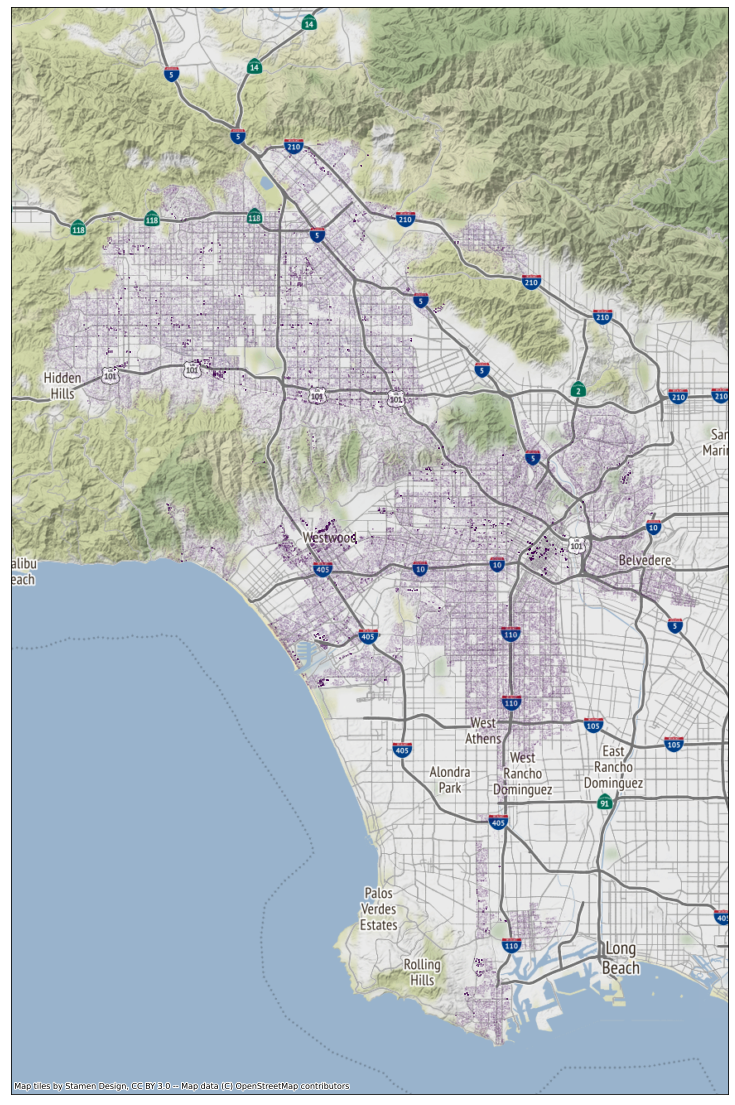

In [164]:
import contextily as ctx
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20))
predictions.to_crs('EPSG:3857').plot('pred_ADU', markersize=0.001, ax=ax)
ctx.add_basemap(ax=ax)
ax.set_xticks([])
ax.set_yticks([])

<div class="alert alert-block alert-info">
<strong>Question:</strong> How might we improve these predictions?
</div>

## Neural networks
Now we've got the syntax nailed down, we can explore other machine learning algorithms.

Most follow a similar format, but have different hyperparameters. For the neural network, for example, we can specify the hidden layers.

However, many other algorithms are more robust if we *standardize* the data - subtract the mean and divide by the standard deviation. This puts each variable on a common scale.

Let's do this. The complication is that we have to exclude the dummy variable columns. 

In [175]:
# see https://scikit-learn.org/stable/modules/preprocessing.html for standardization
from sklearn import preprocessing

dummyCols = [col for col in df_to_fit.columns if col.startswith('_usetype') or col.startswith('usedesc_') or col=='hasADU']
otherCols = [col for col in df_to_fit.columns if col not in dummyCols]

scaler = preprocessing.StandardScaler().fit(df_to_fit[otherCols])

# the scaler returns a numpy array, so we cast this as a DataFrame and need to specify the column names and index
df_scaled = pd.DataFrame(scaler.transform(df_to_fit[otherCols]), columns=otherCols, index=df_to_fit.index)
df_scaled = df_scaled.join(df_to_fit[dummyCols])

df_scaled.head()


,usetype__Commercial,usetype__Government,usetype__Industrial,usetype__Institutional,usetype__Irrigated Farm,usetype__Miscellaneous,usetype__Recreational,usetype__Residential,YearBuilt1,Units1,...,usedesc__Three Units (Any Combination),usedesc__Timber-Pine,usedesc__Two Units,usedesc__Utility Commercial & Mutual: Pumping Plants State Assessed Pr,usedesc__Vineyards,"usedesc__Warehousing, Distribution, Storage",usedesc__Waste,usedesc__Water Recreation,usedesc__Wholesale & Manufacturing Outlets,hasADU
APN,,,,,,,,,,,,,,,,,,,,,
2004-001-003,-0.215099,-0.007444,-0.130268,-0.070096,-0.004681,-0.007444,-0.027795,0.267437,0.202211,-0.099709,...,0,0,0,0,0,0,0,0,0,0
2004-001-004,-0.215099,-0.007444,-0.130268,-0.070096,-0.004681,-0.007444,-0.027795,0.267437,0.202211,-0.099709,...,0,0,0,0,0,0,0,0,0,0
2004-001-005,-0.215099,-0.007444,-0.130268,-0.070096,-0.004681,-0.007444,-0.027795,0.267437,0.202211,-0.099709,...,0,0,0,0,0,0,0,0,0,0
2004-001-008,-0.215099,-0.007444,-0.130268,-0.070096,-0.004681,-0.007444,-0.027795,0.267437,0.235640,-0.099709,...,0,0,0,0,0,0,0,0,0,0
2004-001-009,-0.215099,-0.007444,-0.130268,-0.070096,-0.004681,-0.007444,-0.027795,0.267437,0.235640,-0.099709,...,0,0,0,0,0,0,0,0,0,0


In [176]:
# we can see that the standardization works
df_scaled.describe()

,usetype__Commercial,usetype__Government,usetype__Industrial,usetype__Institutional,usetype__Irrigated Farm,usetype__Miscellaneous,usetype__Recreational,usetype__Residential,YearBuilt1,Units1,...,usedesc__Three Units (Any Combination),usedesc__Timber-Pine,usedesc__Two Units,usedesc__Utility Commercial & Mutual: Pumping Plants State Assessed Pr,usedesc__Vineyards,"usedesc__Warehousing, Distribution, Storage",usedesc__Waste,usedesc__Water Recreation,usedesc__Wholesale & Manufacturing Outlets,hasADU
count,7.759580e+05,7.759580e+05,7.759580e+05,7.759580e+05,7.759580e+05,7.759580e+05,7.759580e+05,7.759580e+05,7.759580e+05,7.759580e+05,...,775958.000000,775958.0,775958.000000,775958.000000,775958.0,775958.000000,775958.0,775958.000000,775958.000000,775958.000000
mean,1.142790e-16,-3.012644e-18,2.871627e-17,5.640696e-18,-4.303778e-19,3.113371e-18,-1.314941e-17,1.728837e-16,-6.080231e-17,2.117092e-17,...,0.022417,0.0,0.069046,0.000036,0.0,0.004110,0.0,0.000001,0.000192,0.019452
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,0.148037,0.0,0.253533,0.006007,0.0,0.063976,0.0,0.001135,0.013856,0.138108
min,-2.150988e-01,-7.444356e-03,-1.302675e-01,-7.009611e-02,-4.680692e-03,-7.444356e-03,-2.779470e-02,-3.739200e+00,-1.298889e+01,-2.249073e-01,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
25%,-2.150988e-01,-7.444356e-03,-1.302675e-01,-7.009611e-02,-4.680692e-03,-7.444356e-03,-2.779470e-02,2.674369e-01,-5.185006e-02,-9.970928e-02,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
50%,-2.150988e-01,-7.444356e-03,-1.302675e-01,-7.009611e-02,-4.680692e-03,-7.444356e-03,-2.779470e-02,2.674369e-01,6.849447e-02,-9.970928e-02,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
75%,-2.150988e-01,-7.444356e-03,-1.302675e-01,-7.009611e-02,-4.680692e-03,-7.444356e-03,-2.779470e-02,2.674369e-01,1.821532e-01,-9.970928e-02,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
max,4.649027e+00,1.343299e+02,7.676509e+00,1.426613e+01,2.136436e+02,1.343299e+02,3.597808e+01,2.674369e-01,5.231294e-01,1.248479e+02,...,1.000000,0.0,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000


In [178]:
# split into train/test as before
X_train, X_test, y_train, y_test = train_test_split(df_scaled[xvars], df_scaled[yvar], test_size = 0.25, random_state = 1)

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)

In [179]:
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    190233
           1       0.63      0.01      0.02      3757

    accuracy                           0.98    193990
   macro avg       0.80      0.50      0.50    193990
weighted avg       0.97      0.98      0.97    193990



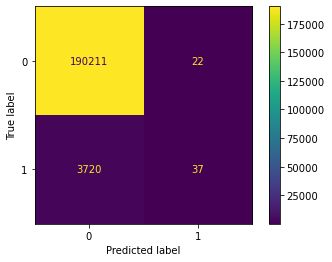

In [180]:
plot_confusion_matrix(mlp, X_test, y_test)

Interestingly, we get very similar results. Perhaps this indicates the inherent unpredictability of ADUs, given how rarely they are constructed. Or we might be able to do better with additional predictors or through adjusting the hyperparameters.

## Logistic regression
As a point of comparison, how would a more traditional logistic regression fare?

Many different regression estimators are implemented in `scikit-learn`. And the syntax should be familiar by now. Note that standardization (as we did for neural networks) helps.



In [185]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

/Users/adammb/anaconda3/envs/urbandatascience/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Note that it doesn't even converge! Methods like logistic regression don't handle highly correlated variables very well.

We might be able to do better with a smaller set of predictors.

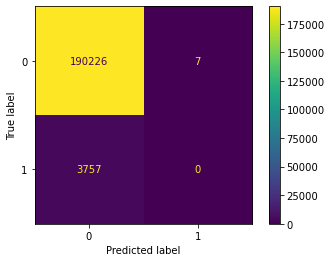

In [192]:
xvars = ['YearBuilt1', 'Units1', 'Bedrooms1', 'Bathrooms1', 'SQFTmain1', 'Roll_LandValue', 
             'Roll_ImpValue', 'Roll_LandBaseYear', 'Roll_ImpBaseYear', 'CENTER_LAT', 'CENTER_LON', 'usedesc__Single']

lr = LogisticRegression()
lr.fit(X_train[xvars], y_train)
plot_confusion_matrix(lr, X_test[xvars], y_test)

Not so great, eh? So our random forests and neural networks approaches look much better by comparison.

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Machine learning is particularly valuable for prediction, and when there are many highly correlated variables.</li>
  <li>There are several different approaches. Random forests and neural networks are two of the most popular.</li>
  <li>scikit-learn provides a consistent syntax: initialize-fit-predict. So once you've done one ML model, others are much simpler.</li>
  <li>Confusion matrices are an excellent way to assess predictive performance.</li>
  <li>We focused here on a binary outcome. But ML also works for continuous outcomes (e.g. air quality) and data with multiple categories (e.g. mode choice).</li>
</ul>
</div>